In [58]:
from keras import losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import Adadelta, SGD, Adam
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
#from scipy.misc import imresize
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from IPython.display import SVG
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import time

## Importing data 

In [59]:
features_data = pd.read_csv("15features.csv")
training_data = pd.read_csv("shuffled-dataset/dataset_seen_training_siamese.csv")
validation_data = pd.read_csv("shuffled-dataset/dataset_seen_validation_siamese.csv")

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)

train_path = 'shuffled-dataset/TrainingSet/'
train_images = os.listdir(train_path)
#print(len(train_images))
val_path = 'shuffled-dataset/ValidationSet/'
val_images = os.listdir(val_path)

columns = features_data.columns



#Get the unique no of values a given feature can take.
features_values = []
for i in columns[1:]:
    #print(i)
    features_values.append(features_data[i].unique().shape[0])
features_values

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

## Datagen

In [60]:
def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = features_data[features_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1

        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=features_values[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

## AutoEncoder

In [61]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=["accuracy"])
autoencoder.load_weights('saved_model_seen_mc.h5')
#autoencoder.summary()

## making the encoder not trainable 

In [62]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
for layer in encoder.layers:
    layer.trainable = False

#encoder.summary()

# Creating 15 DNNs for each feature

In [63]:
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(features_values)+1):
    out_dense_layer.append(Dense(features_values[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten()((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 64, 64, 16)   160         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 32, 32, 16)   0           conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 32, 32, 32)   4640        max_pooling2d_36[0][0]           
__________________________________________________________________________________________________
max_poolin

In [64]:
#SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


## Fitting the model  

In [65]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
#print(losses)
#print(lossWeights)

EPOCHS = 500
INIT_LR = 0.0001
batch_size = 256
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
#human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=["accuracy"])
#human_features.summary()
training_datagen = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
validation_datagen = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
hist = human_features.fit_generator(training_datagen
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1#len(train_images)//batch_size
                                    , validation_data = validation_datagen
                                    , validation_steps = 1#len(train_images)//batch_size
                                    , verbose = 3)
human_features.save_weights("model.h5")

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

7.430084705352783


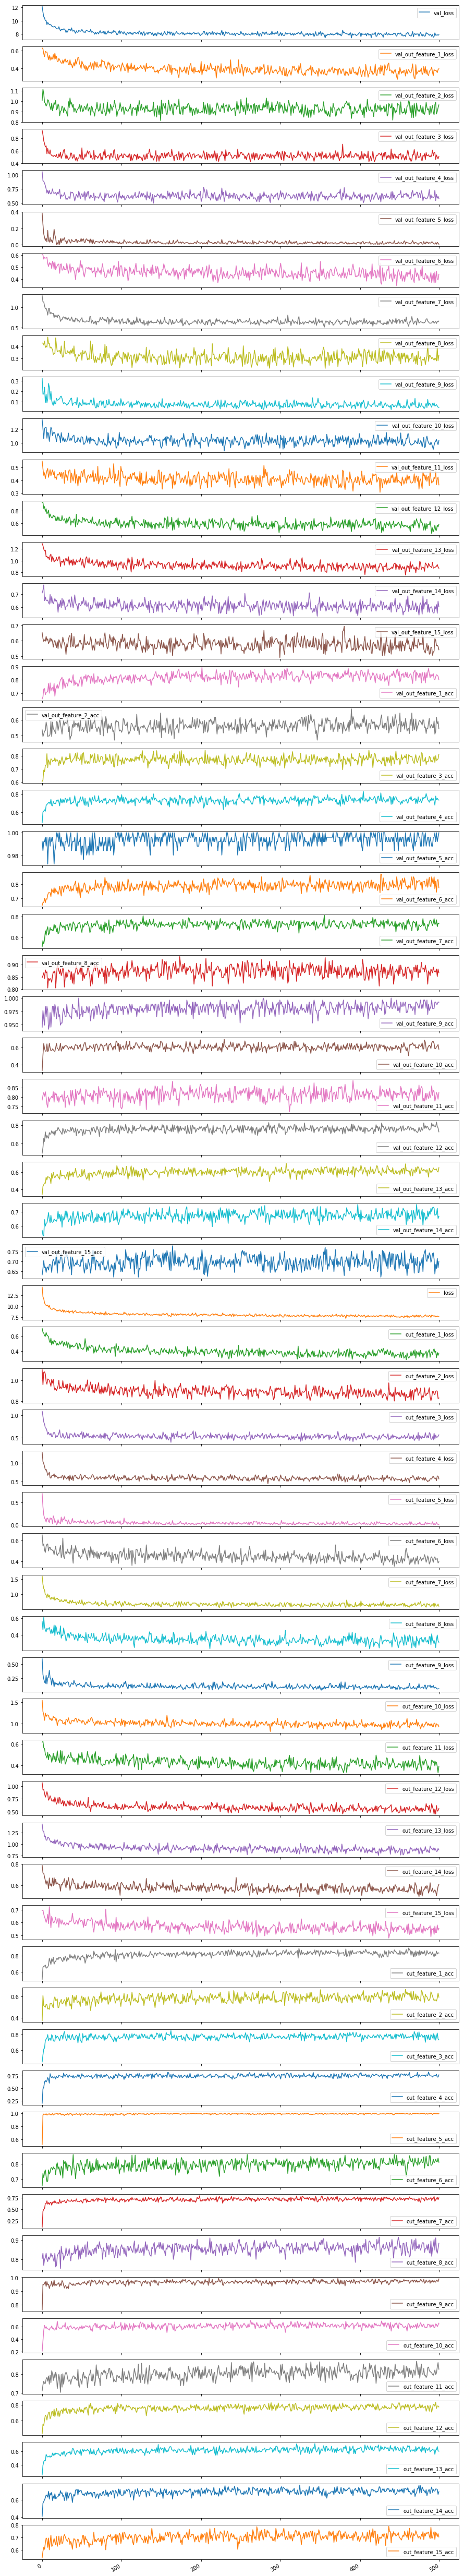

In [66]:

df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
#print(df_hist['acc'])

In [67]:
#human_features.load_weights('model.h5')

## Plotting Results 

In [68]:
vx,vo=next(validation_datagen)
real_rows = []
pred_rows = []
for i in range(64):
    real=[]
    for f in range(15):
        real.append(np.argmax(vo[f][i])+1)
        real_rows.append(real)
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
    pred=[]
    for prob in f_probs:
        pred.append(np.argmax(prob[0])+1)
        pred_rows.append(pred)
counter = 0
 

#print("Accuracy: "+str(counter/len(real_rows)))
#display(real_rows[234])
#display(pred_rows[234:240])

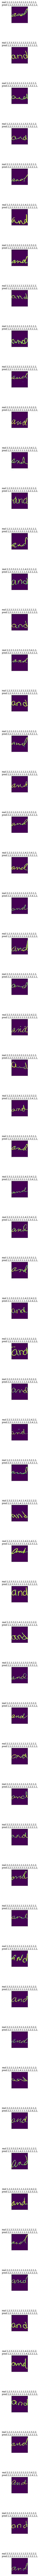

In [69]:
# human_features.load_weights('human_features_weights_v2.h5')
# human_features.load_weights('weights/15-Multitask-FrozenEncoder-unseen_v1.h5')
vx,vo=next(validation_datagen)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

(256, 64, 64, 1) (256, 2)


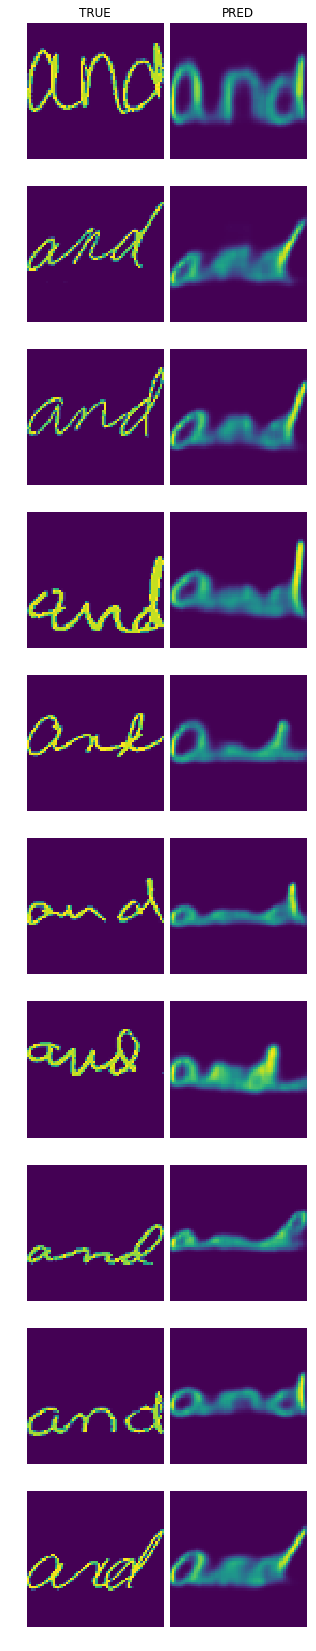

In [70]:
test_g = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
vx,vy = next(test_g)

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')

In [74]:
from scipy.spatial.distance import cosine
from pandas import DataFrame

cols = ['pen_pressure', 'is_lowercase', 'letter_spacing', 'size', 'slantness', 'staff_of_d', 'exit_stroke_d', 'entry_stroke_a', 'dimension', 'is_continuous', 'staff_of_a', 'tilt', 'formation_n', 'constancy', 'word_formation']
sim = []

real_df = pd.DataFrame.from_records(real_rows, columns=cols)
pred_df = pd.DataFrame.from_records(pred_rows, columns=cols)

for i in real_df:
    sim.append(1-cosine(real_df[i],pred_df[i]))
print(sim)

[0.9757731420937115, 0.9471003412030927, 0.9702669274213984, 0.9561016864238912, 1.0, 0.9757731420937115, 0.9103935562156318, 0.960700372373953, 0.9926267353949799, 0.8809945649996959, 0.9756025614503064, 0.9767817382110315, 0.9251293285600278, 0.9164181686540198, 0.9498728291353657]
